In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd /content/drive/My Drive/sensegrass/plant_trait_dataset

/content/drive/My Drive/sensegrass/plant_trait_dataset


In [28]:
!pip install lofo-importance

In [0]:
import warnings
from scipy.stats import ttest_1samp
warnings.filterwarnings("ignore")
from scipy import stats
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import os
import matplotlib.pyplot as plt
from lofo import LOFOImportance, plot_importance

  # Table of Contents
  
  [ 1. Plant nitrogen fixation capacity](#1)
  
  [ 2. Plant growth form](#2)
  
  [ 3. Leaf nitrogen (N) content per leaf dry mass](#3)
  
  [ 4. Leaf photosynthesis rate per leaf area](#4)
  
  [ 5. Leaf photosynthesis pathway](#5)
  
  [ 6. Leaf carbon (C) content per leaf dry mass](#6)
  
  [ 7. Leaf phosphorus (P) content per leaf dry mass](#7)

In [0]:
df = pd.read_csv("trait_data.csv", low_memory=False)

trait_names = df['TraitName'].unique()

In [0]:
imp_cols =['DatasetID', 'ObservationID', 'AccSpeciesID', 'AccSpeciesName', 'TraitID',
           'TraitName', 'DataID', 'DataName', 'OriglName', 'OrigValueStr', 'OrigUnitStr']
df = df[imp_cols]

##  1.Plant nitrogen fixation capacity 

In [0]:
N_fix_cap = df[df['TraitName'] == 'Plant nitrogen(N) fixation capacity']

unique_vals = N_fix_cap['OrigValueStr'].unique()
N_fix_cap = N_fix_cap[N_fix_cap['OrigValueStr'].notna()]
N_fix_cap.head()

,DatasetID,AccSpeciesID,AccSpeciesName,TraitID,TraitName,DataID,DataName,OriglName,OrigValueStr,OrigUnitStr
2,1,909,Achillea millefolium,8.0,Plant nitrogen(N) fixation capacity,9,Nitrogen-fixation capacity,N-fixation,NO-N-fixer,NaN
3,1,2712,Alnus incana,8.0,Plant nitrogen(N) fixation capacity,9,Nitrogen-fixation capacity,N-fixation,N-FIXER,NaN
6,1,3515,Andromeda polifolia,8.0,Plant nitrogen(N) fixation capacity,9,Nitrogen-fixation capacity,N-fixation,NO-N-fixer,NaN
9,1,3738,Angelica sylvestris,8.0,Plant nitrogen(N) fixation capacity,9,Nitrogen-fixation capacity,N-fixation,NO-N-fixer,NaN
12,1,4045,Anthriscus sylvestris,8.0,Plant nitrogen(N) fixation capacity,9,Nitrogen-fixation capacity,N-fixation,NO-N-fixer,NaN


In [0]:
# Cleaning the data
vals_to_replace = {'NO-N-fixer':True, 'N-FIXER':True, 'not N2 fixing':False, 'N2 fixing?':True, '0':False, '1':True, '2':True,
                   'High':True, 'Low':False, 'N2 fixing':True, 'no':False, 'n':False, 'y':True, 'no, not an N fixer':False,
                   'yes, an N fixer':True, 'Medium':True, 'No':False, 'Yes':True, 'yes':True, True:True, False:False, 'N':False, 'Y':True}
N_fix_cap['OrigValueStr'] = N_fix_cap['OrigValueStr'].map(vals_to_replace)
N_fix_cap['OrigUnitStr'] = 'boolean'

In [0]:
N_values = pd.concat([N_fix_cap['AccSpeciesName'],pd.get_dummies(N_fix_cap['OrigValueStr'])], axis = 1)
N_grouped = N_values.groupby('AccSpeciesName').sum().reset_index(drop=False)
N_grouped.columns = ['AccSpeciesName','False','True']

N_grouped['%True'] = N_grouped['True']*100/(N_grouped['True']+N_grouped['False'])
N_grouped['%False'] = 100 - N_grouped['%True']
N_grouped.head()

,AccSpeciesName,False,True,%True,%False
0,ARCTOSTAPHYLOS UVA-URSI,15.0,0.0,0.0,100.0
1,Aa,2.0,0.0,0.0,100.0
2,Abarema,0.0,1.0,100.0,0.0
3,Abarema adenophora,0.0,5.0,100.0,0.0
4,Abarema auriculata,0.0,3.0,100.0,0.0


In [0]:
N_fixed_species = N_grouped[N_grouped['True'] > N_grouped['False']]['AccSpeciesName'].values
N_not_fixed_species = N_grouped[N_grouped['True'] < N_grouped['False']]['AccSpeciesName'].values
unknown_N_fixed_species = N_grouped[N_grouped['True'] == N_grouped['False']]['AccSpeciesName'].values

print("Plants that have nitrogen(N) fixation:  ",N_fixed_species)
print()
print("Plants don't have nitrogen(N) fixation:  ",N_not_fixed_species)

Plants that have nitrogen(N) fixation:   ['Abarema' 'Abarema adenophora' 'Abarema auriculata' ... 'Zygia racemosa'
 'Zygia ramiflora' 'Zygia selloi']

Plants don't have nitrogen(N) fixation:   ['ARCTOSTAPHYLOS UVA-URSI' 'Aa' 'Abarema jupunba var. jupunba' ...
 'Zygocarpum' 'Zygophyllum' 'Zygophyllum fabago']


## 2.Plant growth form <a class="anchor" id="2"></a>

In [0]:
# Plants growth form
plant_growth = df[df['TraitName'] == 'Plant growth form']
plant_growth = plant_growth[imp_cols]

plant_growth['OrigValueStr'] = plant_growth['OrigValueStr'].apply(lambda x: str(x).lower())

In [0]:
tree = ['t','tree (evergreen)','tre','Drink','tree | tree','trees','tree (woody >4m)','smtree','tree']
tree_shurb = ['tree shrub intermediate','tree / shrub','deciduous shrub or tree','tree, shrub','shrub|tree','tree/large shrub','shrub / tree','shrub, tree','shrub or tree','shrub|shrub|tree','tree|shrub|shrub','subshrub, shrub, tree','tree|shrub']
shrub = ['low to high shrub','s','subshrub, shrub','large shrub','subshrub (woody <1m)','sub-shrub (chamaephyte)','sub-shrub','shrub (woody 1-4m)','sh']
grass = ['grasslike','c4 grass','c3 grass','grass (poaceae only)','grass (tussock)','annual grass']
#plant_growth['OrigValueStr'] = plant_growth['OrigValueStr'].replace("f",'forb').replace('forb (herbaceous, with or without woody base)','forb').replace('shrub, graminoid','shrub/graminoid').replace(dict.fromkeys(tree, 'tree')).replace(dict.fromkeys(tree_shurb, 'shrub/tree')).replace('erect dwarf shrub','dwarf shrub').replace(dict.fromkeys(shrub, 'shrub')).replace(dict.fromkeys(grass, 'grass'))

In [0]:
# Grouping the species by most frequent Plant growth form
plant_growth_grouped = plant_growth.groupby('AccSpeciesName')['OrigValueStr'].agg(lambda x:x.value_counts().index[0]).reset_index(drop=False)
plant_growth_grouped.columns = ['AccSpeciesName','Plant growth form']
plant_growth_grouped.head()

,AccSpeciesName,Plant growth form
0,ACAENA NOVAE-ZELANDIAE,climber
1,ADIANTUM CAPILLUS-VENERIS,fern
2,ALISMA PLANTAGO-AQUATICA,hydrophyte
3,APERA SPICA-VENTI,grass
4,ARCTOSTAPHYLOS UVA-URSI,subshrub


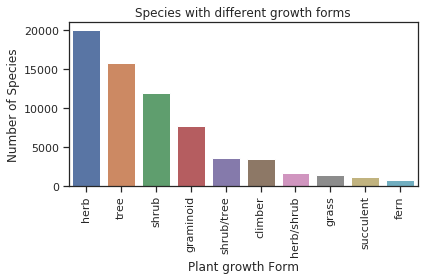

In [0]:
n_species = 10
bar_data = pd.DataFrame(plant_growth_grouped['Plant growth form'].value_counts()).reset_index(drop=False)
bar_data.columns = ['Plant growth Form','Number of Species']
sns.barplot( x= bar_data['Plant growth Form'][:n_species],y = bar_data['Number of Species'][:n_species]).set_title('Species with different growth forms')
plt.xticks(rotation=90)
plt.tight_layout()

## 3.Leaf nitrogen (N) content per leaf dry mass  <a class="anchor" id="3"></a>

In [0]:
nitrogen_content = df[df['TraitName'] == 'Leaf nitrogen (N) content per leaf dry mass']
nitrogen_content = nitrogen_content[imp_cols]
nitrogen_content = nitrogen_content[nitrogen_content['OrigValueStr'].notna()] # dropping nan values

In [0]:
# Cleaning the data
mg_g = ['mg g-1','mg / g','mg_g-1','mg N g-1','mg/g dry mass','g/kg','g kg-1','g mg-1']
percent = ['%','% mass/mass','mg/mg *100']
nitrogen_content['OrigUnitStr']  = nitrogen_content['OrigUnitStr'].replace(dict.fromkeys(mg_g, 'mg/g')).replace('g N g-1 DW', 'g/g').replace(dict.fromkeys(percent, 'percent')).replace('kg/kg','g/g')

In [0]:
# Convert OrigValueStr values string to float type
arr = []
for i in nitrogen_content['OrigValueStr']:
    try: 
        float(i)
    except:
        if i not in arr:
            arr.append(i)
            
nitrogen_content['OrigValueStr'] = nitrogen_content['OrigValueStr'].replace('20-30','25').replace('10-20','15').replace('5-10','7.5').replace('>30','30').replace('<5','5')
nitrogen_content['OrigValueStr'] = nitrogen_content['OrigValueStr'].astype(float)

In [0]:
# Converting values with different units to mg/g

n_percent = nitrogen_content[nitrogen_content['OrigUnitStr'] == 'percent']
n_percent['OrigValueStr'] = n_percent['OrigValueStr']*10
nitrogen_content[nitrogen_content['OrigUnitStr'] == 'percent'] = n_percent
nitrogen_content['OrigUnitStr'] = nitrogen_content['OrigUnitStr'].replace('percent','mg/g')

n_g_g = nitrogen_content[nitrogen_content['OrigUnitStr'] ==  'g/g']
n_g_g['OrigValueStr'] = n_g_g['OrigValueStr']*1000
nitrogen_content[nitrogen_content['OrigUnitStr'] == 'g/g'] = n_g_g
nitrogen_content['OrigUnitStr'] = nitrogen_content['OrigUnitStr'].replace( 'g/g','mg/g')

# mmol/g contains <0.01%, for now, we drop mmol/g
nitrogen_content = nitrogen_content[nitrogen_content['OrigUnitStr'] == 'mg/g']

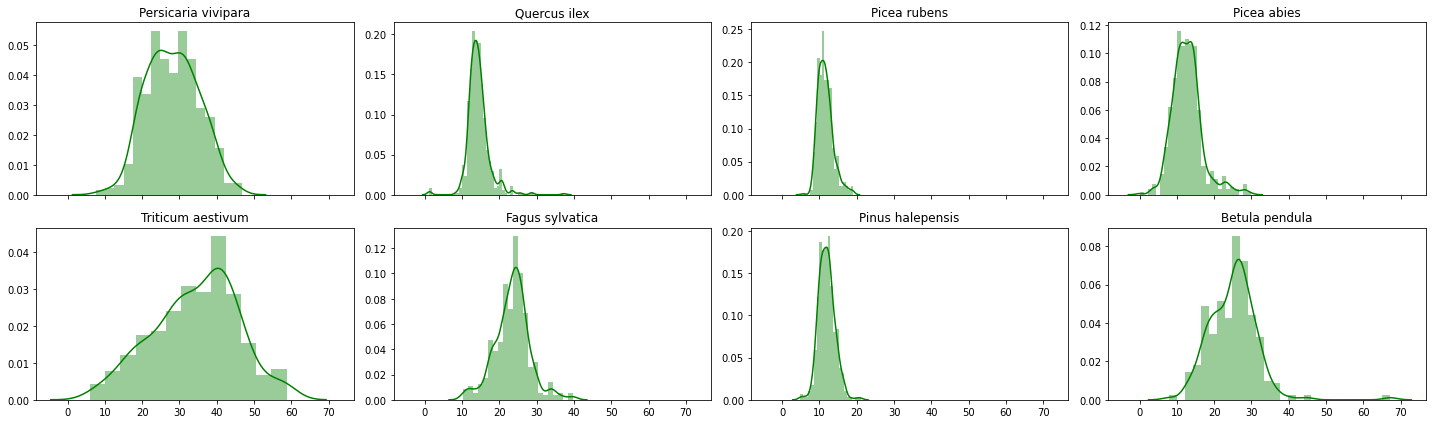

In [0]:
# Distribution of Nitrogen Content in different_species

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Species
species_list = list(dict(nitrogen_content['AccSpeciesName'].value_counts()).keys())

off_set = 1  
shape = (2,4)
fig, axes =plt.subplots(shape[0],shape[1], figsize=(20,6), sharex=True)
axes = axes.flatten()
object_bol = df.dtypes == 'object'
num_species = shape[0]*shape[1]
for ax, species_name in zip(axes, species_list[num_species*off_set: num_species*(1+off_set)]):
    #sns.countplot(y=catplot, data=df, ax=ax, order=np.unique(df.values))
    species_data = nitrogen_content[nitrogen_content['AccSpeciesName'] == species_name]['OrigValueStr'].values
    sns.distplot(species_data, ax=ax, color ='g').set_title(species_name)

plt.tight_layout()
plt.show()

In [0]:
nitrogen_content_grouped = nitrogen_content.groupby(['AccSpeciesName'], as_index=False).agg({'OrigValueStr':['mean','std']})
nitrogen_content_grouped.columns = ['AccSpeciesName','nitrogen_content_mean','nitrogen_content_std']
nitrogen_content_grouped.head()

,AccSpeciesName,nitrogen_content_mean,nitrogen_content_std
0,ALISMA PLANTAGO-AQUATICA,37.700000,10.889444
1,ARCTOSTAPHYLOS UVA-URSI,12.554162,7.430880
2,Aa,26.400000,0.000000
3,Abarema adenophora,24.398311,1.719273
4,Abarema brachystachya,30.400000,NaN


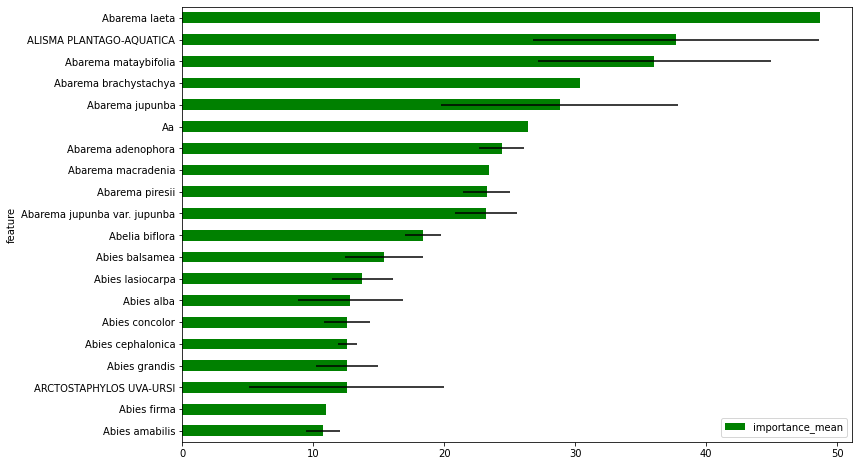

In [0]:
%matplotlib inline
importance_df = nitrogen_content_grouped.copy()
importance_df.columns= ['feature','importance_mean','importance_std']
plot_importance(importance_df[:20], figsize=(12, 8))

[(0.0, 100.0)]

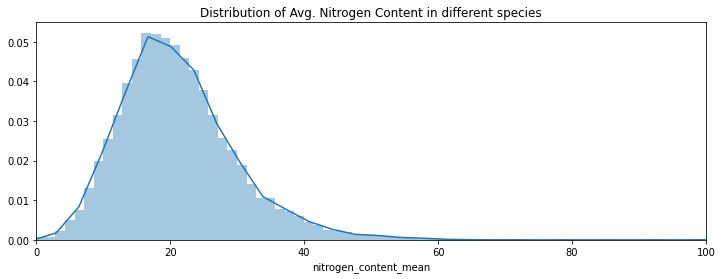

In [0]:
fig,ax = plt.subplots(figsize=(12,4))
sns.distplot(nitrogen_content_grouped['nitrogen_content_mean'], bins = 300).set_title("Distribution of Avg. Nitrogen Content in different species")
ax.set(xlim=(0, 100))

#### P-values for Nitrogen content

In [0]:
from scipy.stats import ttest_1samp

def p_value_test(species_nc_values,species, num_samples = 100):

    print("Mean of nirogen content for '{}':".format(species),np.mean(species_nc_values))
    sample_vals = np.random.choice(species_nc_values, num_samples)
    ttest, p_value = ttest_1samp(sample_vals,np.mean(species_nc_values))
    print("P-Value of {}: {}".format(species, p_value))
    print()
    if p_value < 0.05:
        print('Rejecting the null hyphothesis')
    else:
        print('Failed to reject the null hyphothesis')
    return p_value

P-value of nitrogen content for different species

In [0]:
species = 'Quercus petraea'
species_nc_values = nitrogen_content[nitrogen_content['AccSpeciesName']==species]['OrigValueStr'].values
p_value_test(species_nc_values,species)

Mean of nirogen content for 'Quercus petraea': 21.292878728597625
P-Value of Quercus petraea: 0.161887882172769

Failed to reject the null hyphothesis


0.161887882172769

In [0]:
# P-Values of Nitrogen content for different species
p_vals_nitrogen_content = {}

species_counts = dict(nitrogen_content['AccSpeciesName'].value_counts())

for species_name, num in species_counts.items():
    if num < 70:
        break
    else:
        species_nc_values = nitrogen_content[nitrogen_content['AccSpeciesName'] == species_name]['OrigValueStr'].values
        num_samples = int(num*0.2) # we're taking only 20% samples of total values

        sample_vals = np.random.choice(species_nc_values, num_samples)
        ttest, p_value = ttest_1samp(sample_vals,np.mean(species_nc_values))

        p_vals_nitrogen_content[species_name] = p_value

In [0]:
p_vals_array = np.array(list(p_vals_nitrogen_content.values()))

alpha = 0.01
print("No. of Species that have Nitrogen content P-Value > {} are {:.2f}%".format(alpha, sum(p_vals_array > alpha)*100/len(p_vals_array)))
alpha = 0.05
print("No. of Species that have Nitrogen content P-Value > {} are {:.2f}%".format(alpha, sum(p_vals_array > alpha)*100/len(p_vals_array)))
alpha = 0.1
print("No. of Species that have Nitrogen content P-Value > {} are {:.2f}%".format(alpha, sum(p_vals_array > alpha)*100/len(p_vals_array)))
alpha = 0.2
print("No. of Species that have Nitrogen content P-Value > {} are {:.2f}%".format(alpha, sum(p_vals_array > alpha)*100/len(p_vals_array)))

No. of Species that have Nitrogen content P-Value > 0.01 are 99.44%
No. of Species that have Nitrogen content P-Value > 0.05 are 94.94%
No. of Species that have Nitrogen content P-Value > 0.1 are 87.64%
No. of Species that have Nitrogen content P-Value > 0.2 are 73.60%


## 4.Leaf photosynthesis rate per leaf area <a class="anchor" id="4"></a>

In [0]:
phosy_rate = df[df['TraitName'] == 'Leaf photosynthesis rate per leaf area']
phosy_rate = phosy_rate[imp_cols]
phosy_rate = phosy_rate[phosy_rate['OrigValueStr'].notna()] # dropping nan values

In [0]:
mmms = ['micro mol m-2 s-1','micromol m-2 s-1','micro mol/m2/s','micromol/m2/s','micro mol CO2 m-2 s-1','micro mol C m-2 s-1','micromol. m-2. s-1', ' micro mol m-2 s-1','micromoles/m2/s','micromolco2 m-2 s-1','micromol CO2 m-2 s-1','micromol CO2 m-1s-1','umol CO2 / m2 / sec','umol CO2/m^2 s','umolCO2/m2-s','umol/m2/s','umol CO2 m-2 s-1','umol CO2/m2/s','mol(CO2) m-2 s-1 ']
gmd = ['g m-2 day-1','g/m2/day','g/m2/d']
gcmd = ['g/cm2/d','g/cm2/day']

phosy_rate.OrigUnitStr = phosy_rate.OrigUnitStr.replace(dict.fromkeys(mmms, 'mmol/m2/s')).replace(dict.fromkeys(gmd, 'g/m2/day')).replace(dict.fromkeys(gcmd, 'g/cm2/day')).replace(np.nan, 'mmol/m2/s')
phosy_rate = phosy_rate[phosy_rate['OrigUnitStr']=='mmol/m2/s']

phosy_rate['OrigValueStr'] = phosy_rate['OrigValueStr'].astype('float')
phosy_rate.head()

,DatasetID,ObservationID,AccSpeciesID,AccSpeciesName,TraitID,TraitName,DataID,DataName,OriglName,OrigValueStr,OrigUnitStr
10969,101,1034908,45363,Quercus douglasii,53.0,Leaf photosynthesis rate per leaf area,68,Photosynthesis per leaf area at leaf temperatu...,Photo,5.490,mmol/m2/s
10988,101,1034909,45363,Quercus douglasii,53.0,Leaf photosynthesis rate per leaf area,68,Photosynthesis per leaf area at leaf temperatu...,Photo,-2.970,mmol/m2/s
11007,101,1034910,45363,Quercus douglasii,53.0,Leaf photosynthesis rate per leaf area,68,Photosynthesis per leaf area at leaf temperatu...,Photo,-1.580,mmol/m2/s
11026,101,1034911,45363,Quercus douglasii,53.0,Leaf photosynthesis rate per leaf area,68,Photosynthesis per leaf area at leaf temperatu...,Photo,0.249,mmol/m2/s
11045,101,1034912,45363,Quercus douglasii,53.0,Leaf photosynthesis rate per leaf area,68,Photosynthesis per leaf area at leaf temperatu...,Photo,1.730,mmol/m2/s


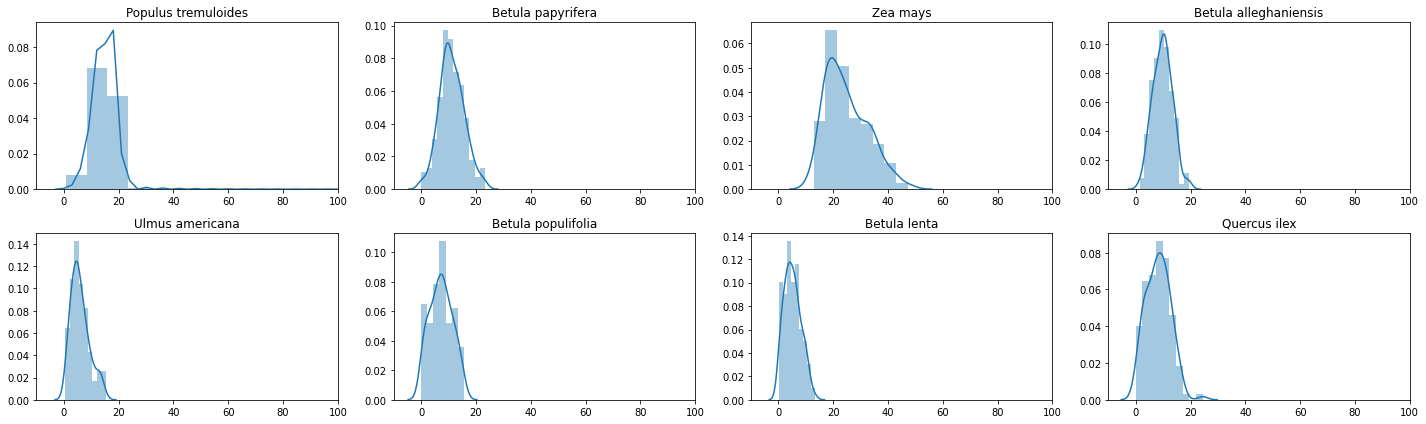

In [0]:
# Distribution of Leaf photosynthesis rate per leaf area in different_species

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Species
species_list = list(dict(phosy_rate['AccSpeciesName'].value_counts()).keys())

off_set = 1  
shape = (2,4)
fig, axes =plt.subplots(shape[0],shape[1], figsize=(20,6), sharex = False)
axes = axes.flatten()
object_bol = df.dtypes == 'object'
num_species = shape[0]*shape[1]

for ax, species_name in zip(axes, species_list[num_species*off_set: num_species*(1+off_set)]):
    #sns.countplot(y=catplot, data=df, ax=ax, order=np.unique(df.values))
    species_data = phosy_rate[phosy_rate['AccSpeciesName'] == species_name]['OrigValueStr'].values
    sns.distplot(species_data, ax=ax).set_title(species_name)
    ax.set_xlim(-10,100)

plt.tight_layout()
plt.show()


In [0]:
phosy_rate_grouped = phosy_rate.groupby(['AccSpeciesName'], as_index=False).agg({'OrigValueStr':['mean','std']})
phosy_rate_grouped.columns = ['AccSpeciesName','phosy_rate_mean','phosy_rate_std']
phosy_rate_grouped.head()

,AccSpeciesName,phosy_rate_mean,phosy_rate_std
0,ALISMA PLANTAGO-AQUATICA,17.010000,NaN
1,APERA SPICA-VENTI,7.000000,3.246097
2,ARCTOSTAPHYLOS UVA-URSI,6.576667,3.562817
3,Abies alba,6.322094,1.158237
4,Abies amabilis,7.612500,0.685097


[(0.0, 100.0)]

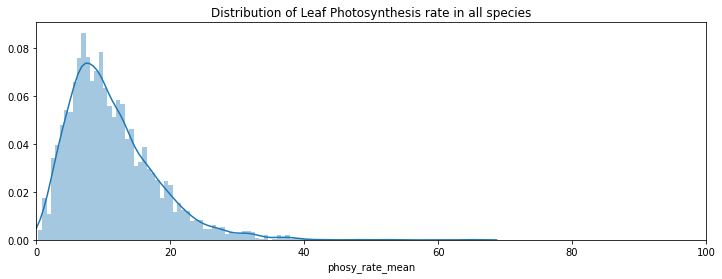

In [0]:
fig,ax = plt.subplots(figsize=(12,4))
sns.distplot(phosy_rate_grouped[phosy_rate_grouped['phosy_rate_mean']<100].phosy_rate_mean, bins = 100).set_title("Distribution of Leaf Photosynthesis rate in all species")
ax.set(xlim=(0, 100))

#### P-Values for photosynthesis rate

In [0]:
# P-Values of photosynthesis rate for different species
p_vals_phosy_rate = {}

species_counts = dict(phosy_rate['AccSpeciesName'].value_counts())

for species_name, num in species_counts.items():
    if num < 70:
        break
    else:
        species_pr_values = phosy_rate[phosy_rate['AccSpeciesName'] == species_name]['OrigValueStr'].values
        num_samples = int(num*0.2) # we're taking only 20% samples of total values

        sample_vals = np.random.choice(species_pr_values, num_samples)
        ttest, p_value = ttest_1samp(sample_vals,np.mean(species_pr_values))

        p_vals_phosy_rate[species_name] = p_value

In [0]:
p_vals_array = np.array(list(p_vals_phosy_rate.values()))

alpha = 0.01
print("No. of Species that have photosynthesis rate P-Value > {} are {:.2f}%".format(alpha, sum(p_vals_array > alpha)*100/len(p_vals_array)))
alpha = 0.05
print("No. of Species that have photosynthesis rate P-Value > {} are {:.2f}%".format(alpha, sum(p_vals_array > alpha)*100/len(p_vals_array)))
alpha = 0.1
print("No. of Species that have photosynthesis rate P-Value > {} are {:.2f}%".format(alpha, sum(p_vals_array > alpha)*100/len(p_vals_array)))
alpha = 0.2
print("No. of Species that have photosynthesis rate P-Value > {} are {:.2f}%".format(alpha, sum(p_vals_array > alpha)*100/len(p_vals_array)))

No. of Species that have photosynthesis rate P-Value > 0.01 are 96.15%
No. of Species that have photosynthesis rate P-Value > 0.05 are 92.31%
No. of Species that have photosynthesis rate P-Value > 0.1 are 92.31%
No. of Species that have photosynthesis rate P-Value > 0.2 are 92.31%


## 5.Leaf photosynthesis pathway <a class="anchor" id="5"></a>

* C3 photosynthesis produces a three-carbon compound via the Calvin cycle 
* C4 photosynthesis makes an intermediate four-carbon compound that splits into a three-carbon compound for the Calvin cycle. 
* Plants that use CAM photosynthesis gather sunlight during the day and fix carbon dioxide molecules at night.

In [0]:
photosyn_pathway = df[df['TraitName']=='Leaf photosynthesis pathway'][imp_cols]

In [0]:
c3 = ['C3?','C3.','3','c3']
c4 = ['C4','C4?','c4']
nan = ['http://tropical.theferns.info/viewtropical.php?id=Vochysia+haenkeana','unknown','no','yes','C3/C4/CAM','C3/C4','C3/CAM','C4/CAM']
photosyn_pathway['OrigValueStr'] = photosyn_pathway['OrigValueStr'].replace(dict.fromkeys(c3, 'C3')).replace('CAM?','CAM').replace(dict.fromkeys(c4, 'C4')).replace(dict.fromkeys(nan, np.nan))
photosyn_pathway = photosyn_pathway[photosyn_pathway['OrigValueStr'].notna()]
photosyn_pathway_grouped = photosyn_pathway.groupby('AccSpeciesName')['OrigValueStr'].agg(lambda x:x.value_counts().index[0]).reset_index(drop=False)

Text(0.5, 1.0, 'Species with different Leaf photosynthesis pathway')

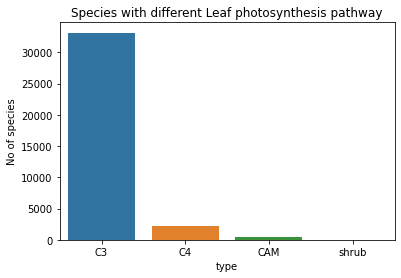

In [0]:
bar_data = pd.DataFrame(photosyn_pathway_grouped.OrigValueStr.value_counts()).reset_index(drop=False)
bar_data.columns = ['type','No of species']
sns.barplot(x = bar_data['type'], y= bar_data['No of species']).set_title('Species with different Leaf photosynthesis pathway')

## 6.Leaf carbon (C) content per leaf dry mass  <a class="anchor" id="6"></a>

In [0]:
carbon_content = df[df['TraitName'] == 'Leaf carbon (C) content per leaf dry mass'][imp_cols]
carbon_content = carbon_content[carbon_content['OrigValueStr'].notna()]
carbon_content = carbon_content[carbon_content['OrigValueStr']!='na']
carbon_content.OrigValueStr = carbon_content.OrigValueStr.astype('float')

In [0]:
mg_g = ['mg/g','g/kg','mg g-1','mg/g dry mass','g mg-1']
g_g = ['g/g','g C g-1 DW']
percent = ['%','percent','mg/mg *100']
carbon_content['OrigUnitStr'] = carbon_content['OrigUnitStr'].replace(dict.fromkeys(mg_g, 'mg/g')).replace(dict.fromkeys(g_g, 'g/g')).replace(dict.fromkeys(percent, 'percent'))

In [0]:
g_g_carbon = carbon_content[carbon_content.OrigUnitStr=='g/g'].OrigValueStr
g_g_carbon *= 100
carbon_content.OrigValueStr[carbon_content.OrigUnitStr=='g/g'] = g_g_carbon
mg_g_carbon = carbon_content[carbon_content.OrigUnitStr=='mg/g'].OrigValueStr 
mg_g_carbon /= 10
carbon_content.OrigValueStr[carbon_content.OrigUnitStr=='mg/g'] = mg_g_carbon
carbon_content['OrigUnitStr'] = carbon_content['OrigUnitStr'].replace(['mg/g','g/g'],['percent','percent'])
carbon_content = carbon_content[carbon_content['OrigUnitStr']=='percent']

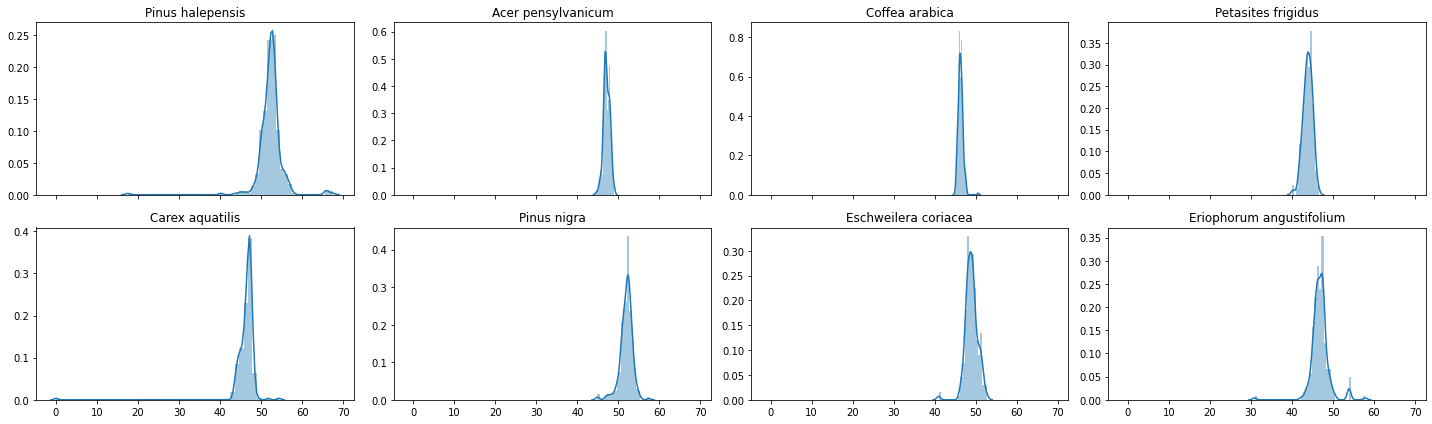

In [0]:
# Distribution of carbon content in different_species

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Species
species_list = list(dict(carbon_content['AccSpeciesName'].value_counts()).keys())

off_set = 1  
shape = (2,4)
fig, axes =plt.subplots(shape[0],shape[1], figsize=(20,6), sharex=True)
axes = axes.flatten()
object_bol = df.dtypes == 'object'
num_species = shape[0]*shape[1]

for ax, species_name in zip(axes, species_list[num_species*off_set: num_species*(1+off_set)]):
    #sns.countplot(y=catplot, data=df, ax=ax, order=np.unique(df.values))
    species_data = carbon_content[carbon_content['AccSpeciesName'] == species_name]['OrigValueStr'].values
    sns.distplot(species_data, ax=ax).set_title(species_name)

plt.tight_layout()  
plt.show()



Text(0.5, 1.0, 'Distribution of carbon content in all species')

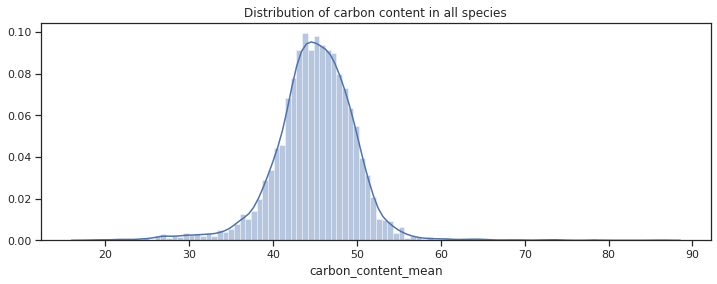

In [0]:
carbon_content_grouped = carbon_content.groupby(['AccSpeciesName'], as_index=False).agg({'OrigValueStr':['mean','std']})
carbon_content_grouped.columns = ['AccSpeciesName','carbon_content_mean','carbon_content_std']
fig,ax = plt.subplots(figsize=(12,4))
sns.distplot(carbon_content_grouped[carbon_content_grouped['carbon_content_mean']<100].carbon_content_mean, bins = 100).set_title("Distribution of carbon content in all species")
#ax.set(xlim=(0, 100))

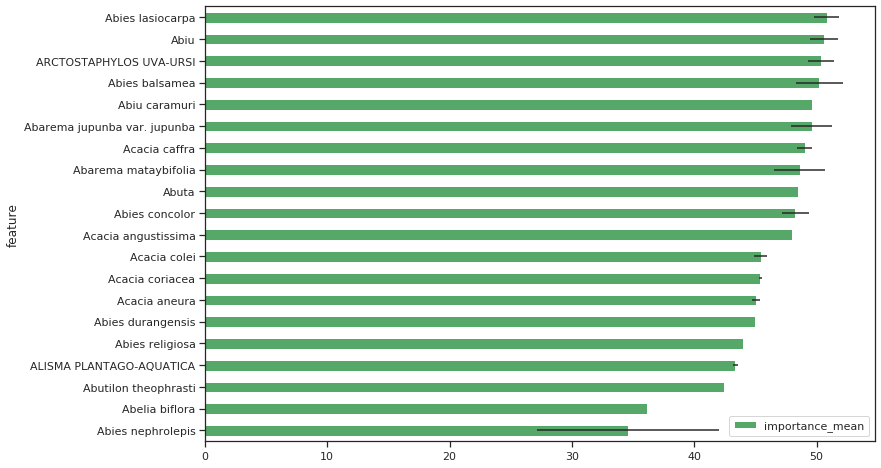

In [0]:
%matplotlib inline
importance_df = carbon_content_grouped.copy()
importance_df.columns= ['feature','importance_mean','importance_std']
plot_importance(importance_df[:20], figsize=(12, 8))

#### P-Values for Carbon Content

In [0]:
# P-Values of Carbon content for different species
p_vals_carbon_content = {}

species_counts = dict(carbon_content['AccSpeciesName'].value_counts())

for species_name, num in species_counts.items():
    if num < 70:
        break
    else:
        species_cc_values = carbon_content[carbon_content['AccSpeciesName'] == species_name]['OrigValueStr'].values
        num_samples = int(num*0.2) # we're taking only 20% samples of total values

        sample_vals = np.random.choice(species_cc_values, num_samples)
        ttest, p_value = ttest_1samp(sample_vals,np.mean(species_cc_values))

        p_vals_carbon_content[species_name] = p_value

# p_vals_carbon_content

In [0]:
p_vals_array = np.array(list(p_vals_carbon_content.values()))

alpha = 0.01
print("No. of Species that have Carbon content P-Value > {:.2f} are {:.2f}%".format(alpha, sum(p_vals_array > alpha)*100/len(p_vals_array)))
alpha = 0.05
print("No. of Species that have Carbon content P-Value > {:.2f} are {:.2f}%".format(alpha, sum(p_vals_array > alpha)*100/len(p_vals_array)))
alpha = 0.1
print("No. of Species that have Carbon content P-Value > {:.2f} are {:.2f}%".format(alpha, sum(p_vals_array > alpha)*100/len(p_vals_array)))
alpha = 0.2
print("No. of Species that have Carbon content P-Value > {:.2f} are {:.2f}%".format(alpha, sum(p_vals_array > alpha)*100/len(p_vals_array)))

No. of Species that have Carbon content P-Value > 0.01 are 100.00%
No. of Species that have Carbon content P-Value > 0.05 are 87.50%
No. of Species that have Carbon content P-Value > 0.10 are 85.71%
No. of Species that have Carbon content P-Value > 0.20 are 73.21%


## 7. Leaf phosphorus (P) content per leaf dry mass <a class="anchor" id="7"></a>

In [0]:
phosphorus_content = df[df['TraitName'] == 'Leaf phosphorus (P) content per leaf dry mass'][imp_cols]
phosphorus_content = phosphorus_content.replace(['1-2','2-3','<1','>3','nd'],['1.5','2.5','1','3',np.nan])
phosphorus_content = phosphorus_content[phosphorus_content['OrigValueStr'].notna()]
phosphorus_content.OrigValueStr = phosphorus_content.OrigValueStr.astype('float')

In [0]:
percent = ['%','% ','% mass/mass','percent']
g_g = ['g P g-1 DW','g/g']
mg_g = ['mg/g','mg g-1','g/kg','mg_g-1']
mg_kg = ['mg kg-1','mg/kg']

phosphorus_content.OrigUnitStr = phosphorus_content.OrigUnitStr.replace(dict.fromkeys(percent, 'percent')).replace(dict.fromkeys(g_g, 'g/g')).replace(dict.fromkeys(mg_g, 'mg/g')).replace(dict.fromkeys(mg_kg, 'mg/kg'))

# converting values with mg/10g, mmol/kg and ppm units to mg/g

mg_10g = phosphorus_content[phosphorus_content.OrigUnitStr=='mg/10g'].OrigValueStr
mg_10g /= 10
phosphorus_content.OrigValueStr[phosphorus_content.OrigUnitStr=='mg/10g'] = mg_10g
phosphorus_content.OrigUnitStr[phosphorus_content.OrigUnitStr=='mg/10g'] = 'mg/g'

phosphorus_content[phosphorus_content.OrigUnitStr=='ppm'].OrigValueStr
ppm = phosphorus_content[phosphorus_content.OrigUnitStr=='ppm'].OrigValueStr
ppm /= 1000
phosphorus_content.OrigValueStr[phosphorus_content.OrigUnitStr=='ppm'] = ppm
phosphorus_content.OrigUnitStr[phosphorus_content.OrigUnitStr=='ppm'] = 'mg/g'

phosphorus_content[phosphorus_content.OrigUnitStr=='mmol/kg'].OrigValueStr
mmol_kg = phosphorus_content[phosphorus_content.OrigUnitStr=='mmol/kg'].OrigValueStr
mmol_kg *= 0.031
phosphorus_content.OrigValueStr[phosphorus_content.OrigUnitStr=='mmol/kg'] = mmol_kg
phosphorus_content.OrigUnitStr[phosphorus_content.OrigUnitStr=='mmol/kg'] = 'mg/g'


phosphorus_content[phosphorus_content.OrigUnitStr=='percent'].OrigValueStr
percent = phosphorus_content[phosphorus_content.OrigUnitStr=='percent'].OrigValueStr
percent *= 10
phosphorus_content.OrigValueStr[phosphorus_content.OrigUnitStr=='percent'] = percent
phosphorus_content.OrigUnitStr[phosphorus_content.OrigUnitStr=='percent'] = 'mg/g'

phosphorus_content[phosphorus_content.OrigUnitStr=='g/g'].OrigValueStr
g_g = phosphorus_content[phosphorus_content.OrigUnitStr=='g/g'].OrigValueStr
g_g *= 1000
phosphorus_content.OrigValueStr[phosphorus_content.OrigUnitStr=='g/g'] = g_g
phosphorus_content.OrigUnitStr[phosphorus_content.OrigUnitStr=='g/g'] = 'mg/g'

phosphorus_content[phosphorus_content.OrigUnitStr=='mg/kg'].OrigValueStr
mg_kg = phosphorus_content[phosphorus_content.OrigUnitStr=='mg/kg'].OrigValueStr
mg_kg /= 1000
phosphorus_content.OrigValueStr[phosphorus_content.OrigUnitStr=='mg/kg'] = mg_kg
phosphorus_content.OrigUnitStr[phosphorus_content.OrigUnitStr=='mg/kg'] = 'mg/g'

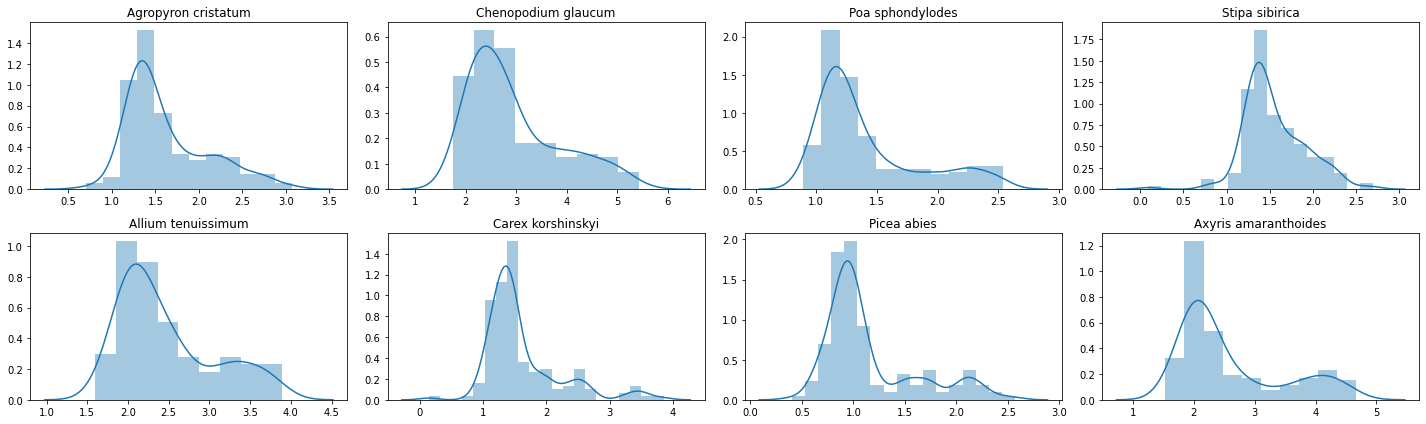

In [0]:
# Distribution of phosphorus content in different_species

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Species
species_list = list(dict(phosphorus_content['AccSpeciesName'].value_counts()).keys())

off_set = 1  
shape = (2,4)
fig, axes =plt.subplots(shape[0],shape[1], figsize=(20,6), sharex=False)
axes = axes.flatten()
object_bol = df.dtypes == 'object'
num_species = shape[0]*shape[1]

for ax, species_name in zip(axes, species_list[num_species*off_set: num_species*(1+off_set)]):
    #sns.countplot(y=catplot, data=df, ax=ax, order=np.unique(df.values))
    species_data = phosphorus_content[phosphorus_content['AccSpeciesName'] == species_name]['OrigValueStr'].values
    sns.distplot(species_data, ax=ax).set_title(species_name)

plt.tight_layout()  
plt.show()

In [0]:
phosphorus_content_grouped = phosphorus_content.groupby(['AccSpeciesName'], as_index=False).agg({'OrigValueStr':['mean','std']})
phosphorus_content_grouped.columns = ['AccSpeciesName','phosphorus_content_mean','phosphorus_content_std']

In [0]:
phosphorus_content_grouped.head()

,AccSpeciesName,phosphorus_content_mean,phosphorus_content_std
0,ADIANTUM CAPILLUS-VENERIS,0.360000,NaN
1,ARCTOSTAPHYLOS UVA-URSI,1.955166,NaN
2,Abarema adenophora,0.840000,NaN
3,Abarema jupunba,0.803333,0.090738
4,Abarema jupunba var. jupunba,0.570000,NaN


#### P-Values for phosphorus content

In [0]:
# P-Values of phosphorus content for different species
p_vals_phosphorus_content = {}

species_counts = dict(phosphorus_content['AccSpeciesName'].value_counts())

for species_name, num in species_counts.items():
    if num < 70:
        break
    else:
        species_pc_values = phosphorus_content[phosphorus_content['AccSpeciesName'] == species_name]['OrigValueStr'].values
        num_samples = int(num*0.2) # we're taking only 20% samples of total values

        sample_vals = np.random.choice(species_pc_values, num_samples)
        ttest, p_value = ttest_1samp(sample_vals,np.mean(species_pc_values))

        p_vals_phosphorus_content[species_name] = p_value

# p_vals_carbon_content

In [0]:
p_vals_array = np.array(list(p_vals_phosphorus_content.values()))

alpha = 0.01
print("No. of Species that have phosphorus content P-Value > {:.2f} are {:.2f}%".format(alpha, sum(p_vals_array > alpha)*100/len(p_vals_array)))
alpha = 0.05
print("No. of Species that have phosphorus content P-Value > {:.2f} are {:.2f}%".format(alpha, sum(p_vals_array > alpha)*100/len(p_vals_array)))
alpha = 0.1
print("No. of Species that have phosphorus content P-Value > {:.2f} are {:.2f}%".format(alpha, sum(p_vals_array > alpha)*100/len(p_vals_array)))
alpha = 0.2
print("No. of Species that have phosphorus content P-Value > {:.2f} are {:.2f}%".format(alpha, sum(p_vals_array > alpha)*100/len(p_vals_array)))

No. of Species that have phosphorus content P-Value > 0.01 are 96.30%
No. of Species that have phosphorus content P-Value > 0.05 are 88.89%
No. of Species that have phosphorus content P-Value > 0.10 are 85.19%
No. of Species that have phosphorus content P-Value > 0.20 are 74.07%


In [0]:
df['OrigUnitStr'] = df['OrigUnitStr'].replace(np.nan, 'NoUnit')
df['Values'] = df['OrigValueStr'] + '/~/' + df['OrigUnitStr']

In [0]:
temp_df = df.groupby('TraitName').filter(lambda x : len(x)>12000)
temp_df['Values'] = temp_df['Values'].astype(str)
temp_df['ObservationID'] = temp_df['ObservationID'].astype(str)
temp_df = temp_df[temp_df['Values'].notna()]

In [0]:
# grouped_df = temp_df.pivot(index='ObservationID', columns='TraitName', values='Values')
# grouped_df = temp_df.groupby(['ObservationID','TraitName'])['Values'].apply(','.join).unstack()

## 8.Water Content

In [0]:
water_content = df[df['TraitName']=='Leaf water content total'][imp_cols]
water_content['OrigValueStr'] = water_content['OrigValueStr'].astype(float)


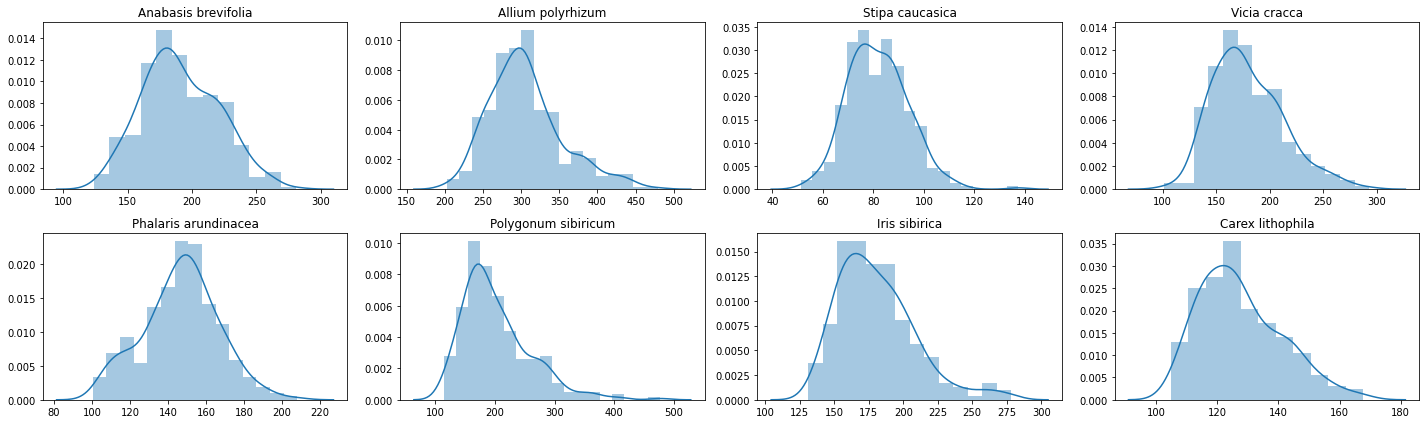

In [32]:
# Distribution of phosphorus content in different_species

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Species
species_list = list(dict(water_content['AccSpeciesName'].value_counts()).keys())

off_set = 1  
shape = (2,4)
fig, axes =plt.subplots(shape[0],shape[1], figsize=(20,6), sharex=False)
axes = axes.flatten()
object_bol = df.dtypes == 'object'
num_species = shape[0]*shape[1]

for ax, species_name in zip(axes, species_list[num_species*off_set: num_species*(1+off_set)]):
    #sns.countplot(y=catplot, data=df, ax=ax, order=np.unique(df.values))
    species_data = water_content[water_content['AccSpeciesName'] == species_name]['OrigValueStr'].values
    sns.distplot(species_data, ax=ax).set_title(species_name)

plt.tight_layout()  
plt.show()

In [0]:
water_content_grouped = water_content.groupby(['AccSpeciesName'], as_index=False).agg({'OrigValueStr':['mean','std']})
water_content_grouped.columns = ['AccSpeciesName','phosphorus_content_mean','phosphorus_content_std']

In [35]:
water_content_grouped.head()

,AccSpeciesName,phosphorus_content_mean,phosphorus_content_std
0,ALISMA PLANTAGO-AQUATICA,284.105769,32.352333
1,Agrostis divaricatissima,171.476320,18.558449
2,Allium polyrhizum,305.813919,48.689273
3,Alopecurus arundinaceus,143.187498,22.101081
4,Anabasis brevifolia,191.099590,29.616713


### P-Values for Water Content

In [0]:
# P-Values of phosphorus content for different species
p_vals_water_content = {}

species_counts = dict(water_content['AccSpeciesName'].value_counts())

for species_name, num in species_counts.items():
    if num < 70:
        break
    else:
        species_pc_values = water_content[water_content['AccSpeciesName'] == species_name]['OrigValueStr'].values
        num_samples = int(num*0.2) # we're taking only 20% samples of total values

        sample_vals = np.random.choice(species_pc_values, num_samples)
        ttest, p_value = ttest_1samp(sample_vals,np.mean(species_pc_values))

        p_vals_water_content[species_name] = p_value


In [0]:
p_vals_array = np.array(list(p_vals_water_content.values()))

alpha = 0.01
print("No. of Species that have Water content P-Value > {:.2f} are {:.2f}%".format(alpha, sum(p_vals_array > alpha)*100/len(p_vals_array)))
alpha = 0.05
print("No. of Species that have Water content P-Value > {:.2f} are {:.2f}%".format(alpha, sum(p_vals_array > alpha)*100/len(p_vals_array)))
alpha = 0.1
print("No. of Species that have Water content P-Value > {:.2f} are {:.2f}%".format(alpha, sum(p_vals_array > alpha)*100/len(p_vals_array)))
alpha = 0.2
print("No. of Species that have Water content P-Value > {:.2f} are {:.2f}%".format(alpha, sum(p_vals_array > alpha)*100/len(p_vals_array)))

No. of Species that have Water content P-Value > 0.01 are 100.00%
No. of Species that have Water content P-Value > 0.05 are 98.00%
No. of Species that have Water content P-Value > 0.10 are 96.00%
No. of Species that have Water content P-Value > 0.20 are 84.00%


# Species wise Analysis 

Grouped the data with ObservationID, where ObservarionID refers to unique ID for each observation plant.

In [0]:
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import os
import matplotlib.pyplot as plt
from lofo import LOFOImportance, plot_importance

# File 'top_traits_data.csv' contains data of only top 122 traits out of 1900
grouped_df = pd.read_csv('top_traits_data.csv')

# 'observation_data.csv' consists of All Species names corresponding to ObservationID's
observation_data = pd.read_csv('observation_data.csv')

# Dropping the rows which have values less than 10 columns
# top_data = grouped_df.dropna(axis=0, thresh=10)

In [0]:
grouped_df.head()

In [0]:
def clean_data(imp_grouped):

    # cleaning the column 'Leaf dry mass (single leaf)'
    dry_mass = imp_grouped[imp_grouped['Leaf dry mass (single leaf)'].notna()]['Leaf dry mass (single leaf)']
    dry_mass = dry_mass.str.split('/~/', 1, expand=True)
    dry_mass.columns = ['Leaf mass','leaf mass units']
    dry_mass['leaf mass units'] = dry_mass['leaf mass units'].replace(' mg','mg').replace('g DM','g')
    dry_mass['Leaf mass'] = dry_mass['Leaf mass'].astype(float)
    mass_g = dry_mass[dry_mass['leaf mass units']=='g']['Leaf mass']
    mass_g *= 1000
    dry_mass['Leaf mass'][dry_mass['leaf mass units']=='g'] = mass_g
    dry_mass['leaf mass units'] = 'mg'
    imp_grouped['Leaf dry mass (single leaf)'][imp_grouped['Leaf dry mass (single leaf)'].notna()] = dry_mass['Leaf mass']

    # Cleaning the column 'Leaf nitrogen (N) content per leaf dry mass'
    col = 'Leaf nitrogen (N) content per leaf dry mass'
    n_content = imp_grouped[imp_grouped[col].notna()][col]
    n_content = n_content.str.split('/~/', 1, expand=True)
    n_content.columns = ['Nitrogen Content','Units']

    mg_g = ['mg g-1','mg / g','mg_g-1','mg N g-1','mg/g dry mass','g/kg','g kg-1','g mg-1']
    percent = ['%','% mass/mass','mg/mg *100']
    n_content['Units']  = n_content['Units'].replace(dict.fromkeys(mg_g, 'mg/g')).replace('g N g-1 DW', 'g/g').replace(dict.fromkeys(percent, 'percent')).replace('kg/kg','g/g')

    n_content['Nitrogen Content'] = n_content['Nitrogen Content'].replace('20-30','25').replace('10-20','15').replace('5-10','7.5').replace('>30','30').replace('<5','5')
    n_content['Nitrogen Content'] = n_content['Nitrogen Content'].astype(float)

    n_percent = n_content[n_content['Units'] == 'percent']
    n_percent['Nitrogen Content'] = n_percent['Nitrogen Content']*10
    n_content[n_content['Units'] == 'percent'] = n_percent
    n_content['Units'] = n_content['Units'].replace('percent','mg/g')

    n_g_g = n_content[n_content['Units'] ==  'g/g']
    n_g_g['Nitrogen Content'] = n_g_g['Nitrogen Content']*1000
    n_content[n_content['Units'] == 'g/g'] = n_g_g
    n_content['Units'] = n_content['Units'].replace( 'g/g','mg/g')
    n_content = n_content[n_content['Units'] == 'mg/g']
    imp_grouped[col][imp_grouped[col].notna()] = n_content['Nitrogen Content']

    # clean the column 'Leaf water content total'
    col = 'Leaf water content total'
    water_content = imp_grouped[imp_grouped[col].notna()][col]
    water_content = water_content.str.split('/~/', 1, expand=True)
    water_content.columns = ['Water Content','Units']
    water_content['Water Content'] = water_content['Water Content'].astype(float)
    imp_grouped[col][imp_grouped[col].notna()] = water_content['Water Content']

    # Cleaning the column 'Plant height vegetative'
    col = 'Plant height vegetative'
    plant_height = imp_grouped[imp_grouped[col].notna()][col]
    plant_height = plant_height.str.split('/~/', 1, expand=True)
    plant_height.columns = ['Plant height','Units']

    replace_vals = ['113.16 cm', '2000 cm*', '2500 cm*', '1000 cm*', '1500 cm*', '108.24 cm', '600 cm*', '68.68 cm',
                    '36.48 cm', '124.24 cm', '329.44 cm', '800 cm*', '120 cm*', '30 cm*', '22.44 cm', '400 cm*', 
                    '69.76 cm', '20 cm*', '12.58 cm', '40 cm*', '60 cm*', '300 cm*', '7.82 cm', '79.6 cm', '15 cm*', 
                    '124.4 cm', '6.28 cm', '50 cm*', '10 c','unknown','a']

    with_vals = ['113.16', '2000', '2500', '1000', '1500', '108.24', '600', '68.68', '36.48', '124.24', 
                 '329.44', '800', '120', '30', '22.44', '400', '69.76', '20', '12.58', '40', '60', '300', 
                 '7.82', '79.6', '15', '124.4', '6.28', '50', '0.1',np.nan,np.nan]

    plant_height['Plant height'] = plant_height['Plant height'].replace(replace_vals,with_vals)
    plant_height['Plant height'] = plant_height['Plant height'].astype(float)

    p_height_m = plant_height[plant_height['Units'] == 'm']['Plant height']
    p_height_m *= 100
    plant_height['Plant height'][plant_height['Units'] == 'm'] = p_height_m

    p_height_mm = plant_height[plant_height['Units'] == 'mm']['Plant height']
    p_height_mm /= 10
    plant_height['Plant height'][plant_height['Units'] == 'mm'] = p_height_mm

    plant_height['Units'] = 'cm'
    imp_grouped[col][imp_grouped[col].notna()] = plant_height['Plant height']

    # Cleaning the column 'Leaf transpiration rate per leaf dry mass'

    col = 'Leaf transpiration rate per leaf dry mass'
    leaf_transp = imp_grouped[imp_grouped[col].notna()][col]
    leaf_transp = leaf_transp.str.split('/~/', 1, expand=True)
    leaf_transp.columns = ['Leaf transpiration rate','Units']
    leaf_transp['Leaf transpiration rate'] = leaf_transp['Leaf transpiration rate'].astype(float)

    mmol_transp = leaf_transp[leaf_transp['Units']=='mmol/g/s']['Leaf transpiration rate']
    mmol_transp *= 64.8
    leaf_transp['Leaf transpiration rate'][leaf_transp['Units']=='mmol/g/s'] = mmol_transp
    leaf_transp['Units'] = 'g(H2O)/g/h'
    imp_grouped[col][imp_grouped[col].notna()] = leaf_transp['Leaf transpiration rate']
    return imp_grouped

In [0]:
# Analysing top important traits
imp_trait_cols = ['Leaf dry mass (single leaf)','Leaf nitrogen (N) content per leaf dry mass','Leaf water content total','Plant height vegetative','Leaf transpiration rate per leaf dry mass']
imp_grouped = grouped_df[imp_trait_cols]
imp_grouped = imp_grouped.dropna(axis=0, thresh=2)
data_df = clean_data(imp_grouped)

data_df.describe()

,Leaf dry mass (single leaf),Leaf nitrogen (N) content per leaf dry mass,Leaf water content total,Plant height vegetative,Leaf transpiration rate per leaf dry mass
count,25732.0,15368.00,13314.0,25659.0,13323.00000
unique,14471.0,10948.00,11564.0,2151.0,4808.00000
top,110.0,26.55,111.0,1500.0,1.25064
freq,61.0,41.00,35.0,430.0,44.00000


In [0]:
# Correlation between all columns

filled_data = data_df.fillna(data_df.mean())
corr = filled_data.corr(method="pearson")
#sns.heatmap(corr)
corr.style.background_gradient(cmap='coolwarm')

,Leaf dry mass (single leaf),Leaf nitrogen (N) content per leaf dry mass,Leaf water content total,Plant height vegetative,Leaf transpiration rate per leaf dry mass
Leaf dry mass (single leaf),1.000000,-0.020007,-0.000000,0.044876,-0.000000
Leaf nitrogen (N) content per leaf dry mass,-0.020007,1.000000,0.000000,-0.029028,0.001631
Leaf water content total,-0.000000,0.000000,1.000000,-0.000000,0.393870
Plant height vegetative,0.044876,-0.029028,-0.000000,1.000000,-0.000000
Leaf transpiration rate per leaf dry mass,-0.000000,0.001631,0.393870,-0.000000,1.000000


In [0]:
data_df = data_df.reset_index()
data_df.columns = ['ObservationID', 'Leaf dry mass (single leaf)',
                       'Leaf nitrogen (N) content per leaf dry mass',
                       'Leaf water content total', 'Plant height vegetative',
                       'Leaf transpiration rate per leaf dry mass']
combined_data = pd.merge(data_df, observation_data, on='ObservationID',how ='left')

In [0]:
combined_data['AccSpeciesName'].value_counts()

Cardamine pratensis              503
Cochlearia officinalis           472
Limonium binervosum              322
Epilobium angustifolium          241
Epilobium tetragonum             219
                                ... 
Thinouia myriantha                 1
Cirsium carniolicum                1
Atalaya multiflora                 1
Minuartia verna subsp. attica      1
Myosotis laxa                      1
Name: AccSpeciesName, Length: 4724, dtype: int64

### Cardamine pratensis

In [0]:
species_name = 'Cardamine pratensis'
c_data = combined_data[combined_data['AccSpeciesName'] == species_name]
filled_data = c_data.fillna(c_data.mean())
corr = filled_data.iloc[:,:].corr(method="pearson")
#sns.heatmap(corr).set_title(species_name)
corr.style.background_gradient(cmap='coolwarm')

,ObservationID,Leaf dry mass (single leaf),Leaf nitrogen (N) content per leaf dry mass,Leaf water content total,Plant height vegetative,Leaf transpiration rate per leaf dry mass
ObservationID,1.000000,0.378552,0.000000,0.000127,-0.236147,-0.000377
Leaf dry mass (single leaf),0.378552,1.000000,-0.000000,0.000000,-0.101271,0.000000
Leaf nitrogen (N) content per leaf dry mass,0.000000,-0.000000,1.000000,-0.000000,0.000000,0.000000
Leaf water content total,0.000127,0.000000,-0.000000,1.000000,0.000000,0.015752
Plant height vegetative,-0.236147,-0.101271,0.000000,0.000000,1.000000,0.000000
Leaf transpiration rate per leaf dry mass,-0.000377,0.000000,0.000000,0.015752,0.000000,1.000000


### Cochlearia officinalis

In [0]:
species_name = 'Cochlearia officinalis'
c_data = combined_data[combined_data['AccSpeciesName'] == species_name]
filled_data = c_data.fillna(c_data.mean())
corr = filled_data.iloc[:,:].corr(method="pearson")
#sns.heatmap(corr).set_title(species_name)
corr.style.background_gradient(cmap='coolwarm')

,ObservationID,Leaf dry mass (single leaf),Leaf nitrogen (N) content per leaf dry mass,Leaf water content total,Plant height vegetative,Leaf transpiration rate per leaf dry mass
ObservationID,1.000000,-0.002606,0.000000,0.004013,-0.000000,-0.002140
Leaf dry mass (single leaf),-0.002606,1.000000,0.000000,0.000000,0.000000,0.000000
Leaf nitrogen (N) content per leaf dry mass,0.000000,0.000000,1.000000,-0.000000,-1.000000,-0.000000
Leaf water content total,0.004013,0.000000,-0.000000,1.000000,0.000000,-0.263275
Plant height vegetative,-0.000000,0.000000,-1.000000,0.000000,1.000000,0.000000
Leaf transpiration rate per leaf dry mass,-0.002140,0.000000,-0.000000,-0.263275,0.000000,1.000000


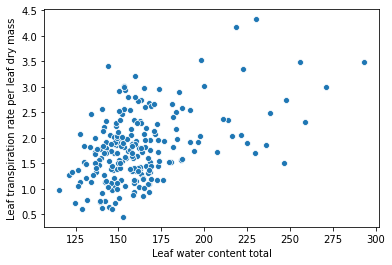

In [0]:
sns.scatterplot(data=filled_data, x = 'Leaf water content total',y ='Leaf transpiration rate per leaf dry mass')

### Limonium binervosum

In [0]:
species_name = 'Limonium binervosum'
c_data = combined_data[combined_data['AccSpeciesName'] == species_name]
filled_data = c_data.fillna(c_data.mean())
corr = filled_data.iloc[:,:].corr(method="pearson")
#sns.heatmap(corr).set_title(species_name)
corr.style.background_gradient(cmap='coolwarm')

,ObservationID,Leaf dry mass (single leaf),Leaf nitrogen (N) content per leaf dry mass,Leaf water content total,Plant height vegetative,Leaf transpiration rate per leaf dry mass
ObservationID,1.000000,nan,nan,-0.003369,0.000000,0.001707
Leaf dry mass (single leaf),nan,nan,nan,nan,nan,nan
Leaf nitrogen (N) content per leaf dry mass,nan,nan,nan,nan,nan,nan
Leaf water content total,-0.003369,nan,nan,1.000000,-0.000000,-0.414952
Plant height vegetative,0.000000,nan,nan,-0.000000,1.000000,0.000000
Leaf transpiration rate per leaf dry mass,0.001707,nan,nan,-0.414952,0.000000,1.000000


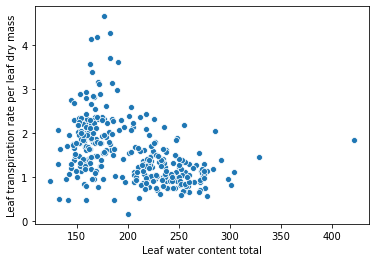

In [0]:
sns.scatterplot(data=filled_data, x = 'Leaf water content total',y ='Leaf transpiration rate per leaf dry mass')
plt.show()


# x,y = 'Leaf water content total', 'Leaf transpiration rate per leaf dry mass'
# sns.lmplot(data=filled_data, x=x, y=y, fit_reg=False,scatter_kws={"color":"darkred","alpha":0.3,"s":100})
# plt.show()

### Epilobium angustifolium

In [0]:
species_name = 'Epilobium angustifolium'
c_data = combined_data[combined_data['AccSpeciesName'] == species_name]
filled_data = c_data.fillna(c_data.mean())
corr = filled_data.iloc[:,:].corr(method="pearson")
#sns.heatmap(corr).set_title(species_name)
corr.style.background_gradient(cmap='coolwarm')

,ObservationID,Leaf dry mass (single leaf),Leaf nitrogen (N) content per leaf dry mass,Leaf water content total,Plant height vegetative,Leaf transpiration rate per leaf dry mass
ObservationID,1.000000,nan,-0.596030,0.000381,-0.588452,0.000305
Leaf dry mass (single leaf),nan,nan,nan,nan,nan,nan
Leaf nitrogen (N) content per leaf dry mass,-0.596030,nan,1.000000,0.000000,0.854188,-0.000000
Leaf water content total,0.000381,nan,0.000000,1.000000,-0.000000,0.795947
Plant height vegetative,-0.588452,nan,0.854188,-0.000000,1.000000,-0.000000
Leaf transpiration rate per leaf dry mass,0.000305,nan,-0.000000,0.795947,-0.000000,1.000000


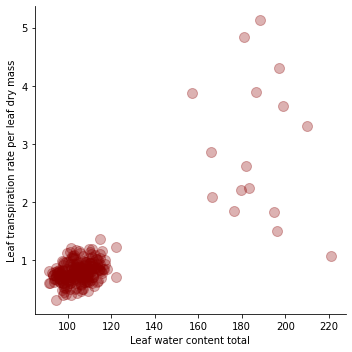

In [0]:

x,y = 'Leaf water content total', 'Leaf transpiration rate per leaf dry mass'
sns.lmplot(data=filled_data, x=x, y=y, fit_reg=False,scatter_kws={"color":"darkred","alpha":0.3,"s":100})


### Epilobium tetragonum

In [0]:
species_name = 'Epilobium tetragonum'
c_data = combined_data[combined_data['AccSpeciesName'] == species_name]
filled_data = c_data.fillna(c_data.mean())
corr = filled_data.iloc[:,:].corr(method="pearson")
#sns.heatmap(corr).set_title(species_name)
corr.style.background_gradient(cmap='coolwarm')

,ObservationID,Leaf dry mass (single leaf),Leaf nitrogen (N) content per leaf dry mass,Leaf water content total,Plant height vegetative,Leaf transpiration rate per leaf dry mass
ObservationID,1.000000,nan,0.000000,-0.000006,nan,0.000263
Leaf dry mass (single leaf),nan,nan,nan,nan,nan,nan
Leaf nitrogen (N) content per leaf dry mass,0.000000,nan,1.000000,-0.000000,nan,0.000000
Leaf water content total,-0.000006,nan,-0.000000,1.000000,nan,0.468168
Plant height vegetative,nan,nan,nan,nan,nan,nan
Leaf transpiration rate per leaf dry mass,0.000263,nan,0.000000,0.468168,nan,1.000000


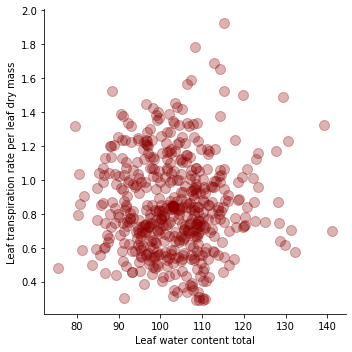

In [0]:
sns.lmplot(data=filled_data, x = 'Leaf water content total',y ='Leaf transpiration rate per leaf dry mass',fit_reg=False,scatter_kws={"color":"darkred","alpha":0.3,"s":100})

In [0]:
combined_filled_mean = combined_data.fillna(combined_data.mean())
combined_filled_mean.head()

,ObservationID,Leaf dry mass (single leaf),Leaf nitrogen (N) content per leaf dry mass,Leaf water content total,Plant height vegetative,Leaf transpiration rate per leaf dry mass,AccSpeciesName
0,34291,593.256514,34.965271,159.544647,1060.800000,1.564961,Warburgia stuhlmannii
1,34292,593.256514,24.155819,159.544647,626.000000,1.564961,Pseudospondias microcarpa
2,34293,593.256514,41.555991,159.544647,708.000000,1.564961,Phytolacca dodecandra
3,34294,593.256514,28.624840,159.544647,1316.750000,1.564961,Erodium botrys
4,34298,593.256514,39.931802,159.544647,1194.291632,1.564961,Ardisia compressa


In [0]:
combined_filled_mean

Text(0.5, 1.0, 'Distribution of correlation values (Leaf Nitrogen vs Leaf transpiration)')

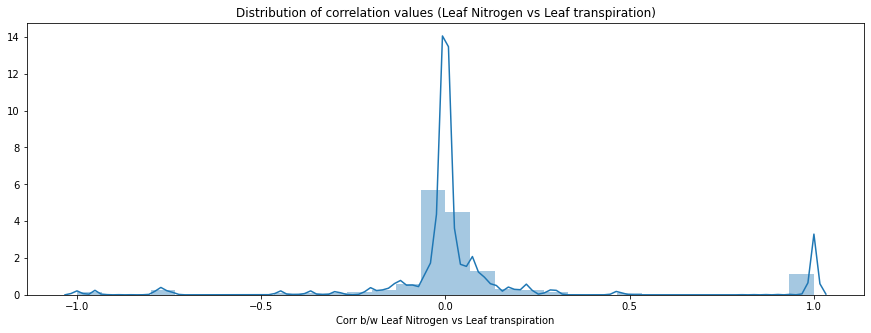

In [0]:
col = ['Leaf nitrogen (N) content per leaf dry mass','Leaf transpiration rate per leaf dry mass']
corr_data = combined_filled_mean.groupby('AccSpeciesName')[col].corr().unstack().iloc[:,1]

corr_data = pd.DataFrame(corr_data).reset_index(drop=False)
corr_cols = ['AccSpeciesName','Corr b/w Leaf Nitrogen vs Leaf transpiration']
corr_data.columns = corr_cols
corr_data = corr_data[corr_data[corr_cols[1]].notna()]
fig,ax = plt.subplots(figsize=(15,5))
sns.distplot(corr_data[corr_cols[1]], ax = ax, bins = 30).set_title('Distribution of correlation values (Leaf Nitrogen vs Leaf transpiration)')

(-1.0, 1.0)

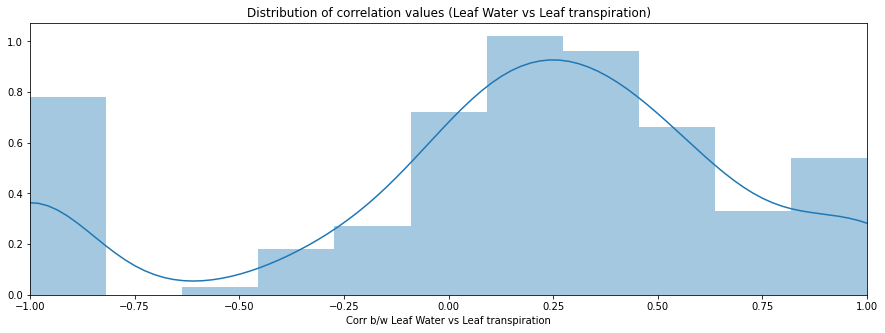

In [0]:
col = ['Leaf water content total','Leaf transpiration rate per leaf dry mass']
corr_data = combined_filled_mean.groupby('AccSpeciesName')[col].corr().unstack().iloc[:,1]

corr_data = pd.DataFrame(corr_data).reset_index(drop=False)
corr_cols = ['AccSpeciesName','Corr b/w Leaf Water vs Leaf transpiration']
corr_data.columns = corr_cols
corr_data = corr_data[corr_data[corr_cols[1]].notna()]
fig,ax = plt.subplots(figsize=(15,5))
sns.distplot(corr_data[corr_cols[1]], ax = ax).set_title('Distribution of correlation values (Leaf Water vs Leaf transpiration)')
plt.xlim(-1,1)

(-1.0, 1.0)

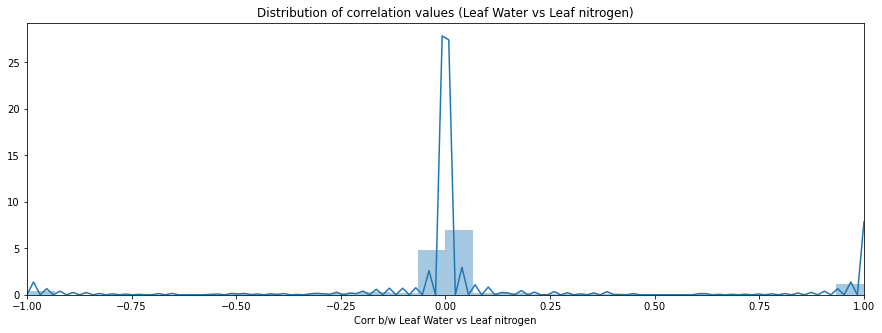

In [0]:
col = ['Leaf water content total','Leaf nitrogen (N) content per leaf dry mass']
corr_data = combined_filled_mean.groupby('AccSpeciesName')[col].corr().unstack().iloc[:,1]

corr_data = pd.DataFrame(corr_data).reset_index(drop=False)
corr_cols = ['AccSpeciesName','Corr b/w Leaf Water vs Leaf nitrogen']
corr_data.columns = corr_cols
corr_data = corr_data[corr_data[corr_cols[1]].notna()]
fig,ax = plt.subplots(figsize=(15,5))
sns.distplot(corr_data[corr_cols[1]], ax = ax, bins = 30).set_title('Distribution of correlation values (Leaf Water vs Leaf nitrogen)')
plt.xlim(-1,1)